In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
G = 4.5
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz_re.mat')

In [3]:
channelnumber = 52
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
from PIfunc import PIfunc
from EqualState import EqualState

(150, 160)

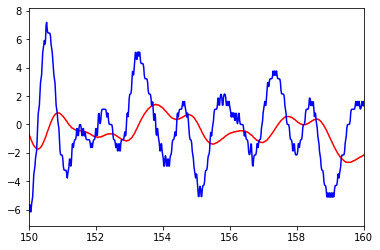

In [5]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
# x = np.random.randn(len(x))
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [6]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.7267072741670553

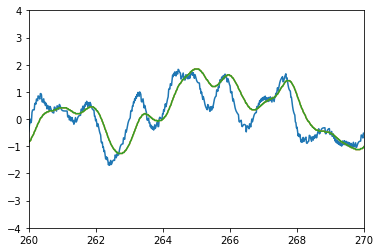

In [26]:
##response
# Model one: simple estimation
deltaT = 0
r1 = x+v*deltaT

# Model Two: negative group delay
# #following paremeters match x+v*0.5s
alpha = 60.
beta =  2
K = 30.
g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
# alpha = 20.
# beta =  0.3
# K = 20.
# g = 30.
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= (y-np.mean(y))/np.std(y)
r1= (r1-np.mean(r1))/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.plot(T,x)
plt.xlim(260,270)
plt.ylim(-4,4)
    
#Chose which one to be response
r = r1

In [27]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
#rstate = np.random.poisson(rstate)
rstate = rstate.astype(int)
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)
ystate, edges = EqualState(y, 6)

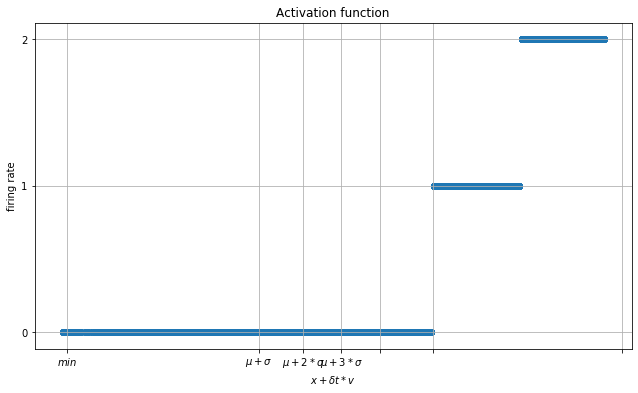

In [28]:
plt.scatter(r, rstate)
plt.title('Activation function')
plt.gcf().set_size_inches(10.7, 6)
plt.xticks(edges, [r'$min$', r'$\mu+\sigma$',r'$\mu+2*\sigma$',r'$\mu+3*\sigma$'])
plt.yticks(np.unique(rstate))
plt.ylabel('firing rate')
plt.xlabel(r'$x+\delta t*v$')
plt.grid(True)
plt.savefig('Active function')

In [29]:
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
FUx_peaktime= timeshift[int(np.mean(np.where(Ux == max(Ux))))]
FUv_peaktime=timeshift[int(np.mean(np.where(Uv == max(Uv))))]
FSyn_peaktime= timeshift[int(np.mean(np.where(Syner == max(Syner))))]
FRdn_peaktime= timeshift[int(np.mean(np.where(Redun == max(Redun))))]
FUx_peakH= max(Ux)
FUv_peakH= max(Uv)
FSyn_peakH= max(Syner)
FRdn_peakH= max(Redun)

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: divide by zero encountered in log2
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: invalid value encountered in multiply
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: divide by zero encountered in log2
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: invalid value encountered in multiply
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:58: RuntimeWarning: divide by zero encountered in log2
  PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:58: RuntimeWarning: invalid value encountered in multiply
  PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
C

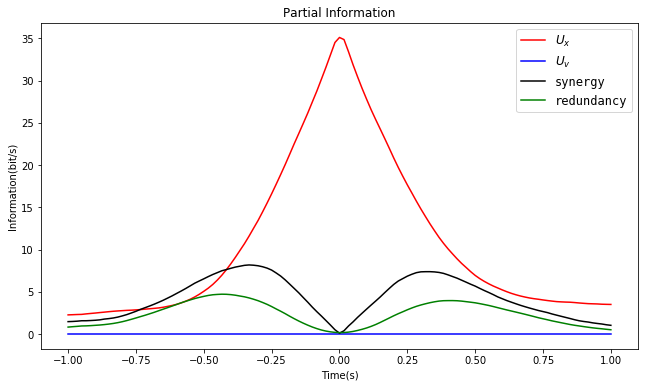

In [30]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title('Partial Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

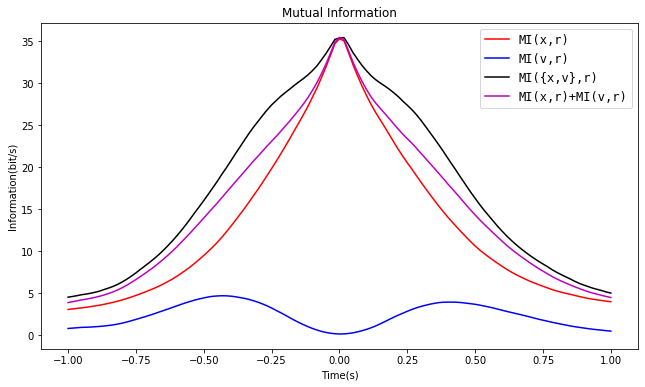

In [31]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

In [13]:
# for i in range(np.size(annots['reconstruct_spikes'])):
#     print( i, np.size(annots['reconstruct_spikes'][0][i]))

In [14]:
N, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
np.unique(N)

array([0, 1, 2, 3, 4, 5, 6, 8], dtype=int64)

In [15]:
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(N, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
RUx_peaktime= timeshift[int(np.mean(np.where(Ux == max(Ux))))]
RUv_peaktime=timeshift[int(np.mean(np.where(Uv == max(Uv))))]
RSyn_peaktime= timeshift[int(np.mean(np.where(Syner == max(Syner))))]
RRdn_peaktime= timeshift[int(np.mean(np.where(Redun == max(Redun))))]
RUx_peakH= max(Ux)
RUv_peakH= max(Uv)
RSyn_peakH= max(Syner)
RRdn_peakH= max(Redun)

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: divide by zero encountered in log2
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: invalid value encountered in multiply
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: divide by zero encountered in log2
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: invalid value encountered in multiply
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: divide by zero encountered in log2
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: invalid value encountered in multiply
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Docu

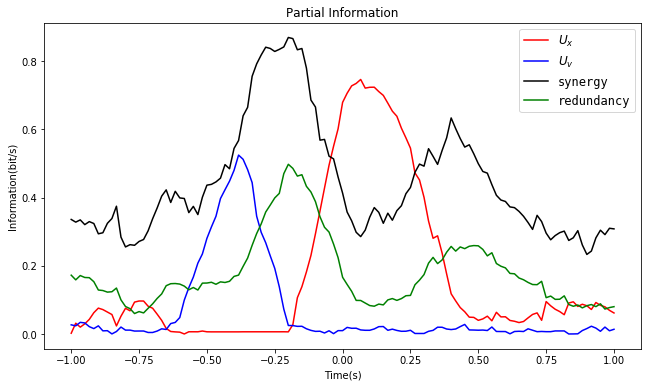

In [16]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title('Partial Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.savefig('ch.'+str(channelnumber)+'_PI.tiff')

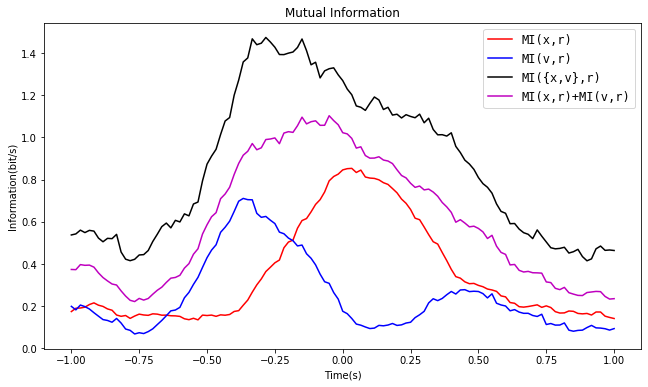

In [17]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.savefig('ch.'+str(channelnumber)+'_MI.tiff')

In [18]:
#plz ignore following

In [19]:
max(Uv)/max(Ux)

0.702893697933352

In [20]:
print(RUv_peaktime, FUv_peaktime)
print(RSyn_peaktime-RUv_peaktime, FSyn_peaktime-FUv_peaktime)
print(RRdn_peaktime-RUv_peaktime, FRdn_peaktime-FUv_peaktime)
print(RUx_peaktime-RUv_peaktime, FUx_peaktime-FUv_peaktime)
print('if matched, the progressing time = '+str(round(FUv_peaktime-RUv_peaktime, 3))+'(s)')

-0.3833333333333333 0.0
0.18333333333333335 0.2333333333333334
0.18333333333333335 0.25
0.44999999999999996 0.3999999999999999
if matched, the progressing time = 0.383(s)


In [21]:
print(RUv_peakH, FUv_peakH)
print(RSyn_peakH/RUv_peakH, FSyn_peakH/FUv_peakH)
print(RRdn_peakH/RUv_peakH, FRdn_peakH/FUv_peakH)
print(RUx_peakH/RUv_peakH, FUx_peakH/FUv_peakH)

0.5248723533403956 34.93142622760733
1.6574813670176791 0.1642124075031094
0.9486020121627792 0.13252745341371833
1.4226902345834085 0.19314636298543983


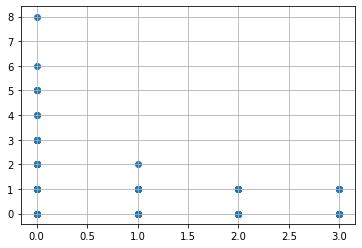

In [22]:
plt.scatter(rstate, N)
plt.grid(True)

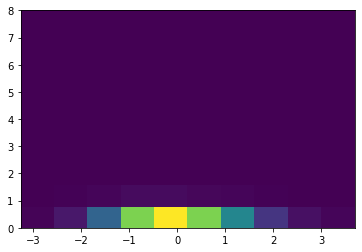

In [23]:
hst = plt.hist2d(r, N)

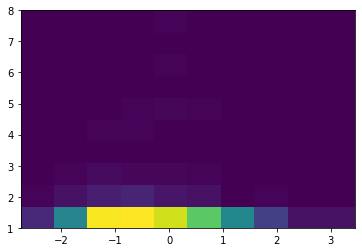

In [24]:
Nn = N[np.where(N != 0)]
Rr = r[np.where(N != 0)]
hst = plt.hist2d(Rr, Nn)

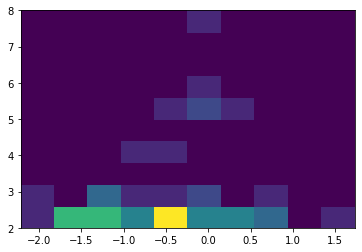

In [25]:
Rr = Rr[np.where(Nn != 1)]
Nn = Nn[np.where(Nn != 1)]
hst = plt.hist2d(Rr, Nn)